#### Brief intro

Neural networks mimic the way the human brain works. They inherit some important characteristics of human brain, e.g. multiple neurons, multiple layers, information propagation and aggregation, and target-aware network adaptation. Fully Connected Neural Networks, AKA the multi-layer perceptrons (MLP), represents the vanilla architecture of neural networks, where a neuron always connects to all the neurons in the next layer of the neural network. In comparison to the CNN networks, the neurons have full access to the information in its previous layer. While due to co-adaptation of the neurons during network training, the neurons will evolve and differentiate with each other to form an asymptotic function of the target 'Optimal' solution for the given knowledge pool (the given training set. While whether the training set reprents well the real-world problem or not is another question which is beyound the scope of the learning process to reveal.). 

#### Layer Initialization
The neurons within a layer are functionally the same. If we initialize the neurons with same weights, then all neurons will evolve the same way, and the whole layer will function exactly like one single neuron. This prevents the neurons from evolving differently to form a complex function. In the initialization stage, one of the target is to handle this 'symmetry problem' by initialize the weights of neurons in each layer with different weight values, e.g randnorm, truncatednorm.

#### Personal Thoughts
Theoretically, neurons within each layer have equal potential to become a specific neuron needed in this layer before initialization. However, due to the initialization and the training process, they will evolve differently as determined by the global loss criteria. Like cells in human body, the neurons also gradually differentiate with each other with time, and acquire specific functionalities, e.g specific and stable weight configurations. The interesting thing is, they will follow the system needs and have no resistance to loss their flexibilities and become specified, just like tools used by a soul (target function). 

#### Let code say


In [30]:
## load libs supporting the implementation
%matplotlib inline
import warnings
warnings.filterwarnings('ignore') ## ignore warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata ## to load mnist
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder

#### load mnist mdataset 

In [31]:
mnist = fetch_mldata('mnist original', data_home = 'datasets')
X, y = mnist['data'], mnist['target'] ##  X: features, y: targets
X.shape, y.shape ## tensor shape check

((70000, 784), (70000,))

#### Preprocess dataset

In [32]:
X = X.T  ## reshape X as (n_features, n_samples)
X = X/255.0  ## scale features into [0,1] 
Y = OneHotEncoder().fit_transform(y.reshape(-1,1).astype('int32')).toarray().T ## onehot encode y into Y of shape: (n_classes, n_samples)
X.shape, Y.shape ## tensor shape check

((784, 70000), (10, 70000))

#### Make train/test splits

In [4]:
m = 60000 ## cut point for train/test sets
X_train, Y_train = X[:,:m], Y[:,:m]
X_test , Y_test  = X[:,m:], Y[:,m:]
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape ## tensor shape check

((784, 60000), (10, 60000), (784, 10000), (10, 10000))

#### Randomly shuffle trainset

In [5]:
np.random.seed(12345) ## for reproducibility
shuffle = np.random.permutation(m) ## create shuffle index
X_train, Y_train = X_train[:, shuffle], Y_train[:, shuffle]
X_train.shape, Y_train.shape ## shape check

((784, 60000), (10, 60000))

#### Visual check

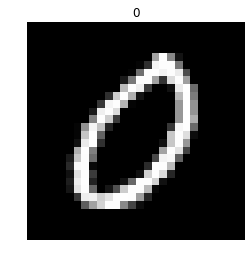

In [6]:
sample = 1234
plt.imshow(X_train[:,sample].reshape(28,-1), cmap = 'binary_r')
plt.axis('off')
plt.title(np.argmax(Y_train[:,sample]))
plt.show()

#### Implement MLP

So far so good. After preparation of the training/testing sets, it's time to code the neural network, which comprises of:

    Input layer, with forward connections to Hidden layer
    Hidden layer, with backward connections to Input layer, and forward connections to Output layer
    Output layer, with backward connections to Hidden layer.
    
The loss function is choosen as the cross-entropy loss, and optimizer is set with vanilla gradient descent with a constant learning rate.

#### Set params

In [15]:
n_samples   = 60000
input_dims  = 784 
hidden_dims = 128
output_dims = 10
lr = 1

#### Initialize weights/bias (they are what to train)

In [16]:
W1 = np.random.randn(hidden_dims, input_dims) ## info are squeezed in each neuron, as hidden_dims << input_dims
b1 = np.zeros((hidden_dims,1)) ## bias 1
W2 = np.random.randn(output_dims, hidden_dims) ## to target 
b2 = np.zeros((output_dims, 1)) ## bias 2

####  Train network

In [24]:
for epoch in range(200):

    ## Calculate output
    Z1 = W1 @ X_train + b1 ## affine (rotate, scale, translate)
    A1 = 1 / (1 + np.exp(-Z1)) ## sigmoid
    Z2 = W2 @ A1 + b2 ## affine
    A2 = np.exp(Z2)/np.exp(Z2).sum(axis = 0) ## softmax

    ## Calculate Loss 
    Loss = - np.sum(Y_train * np.log(A2))/n_samples ## cross-entropy loss

    ## Calculate derivatives
    dZ2 = A2 - Y_train ## loss derivative to Z2
    dW2 = dZ2 @ A1.T/n_samples ## loss derivative to W2 
    db2 = dZ2.mean(axis = 1, keepdims = True) ## keep the shape

    dA1 = W2.T @ dZ2 ## chain rule
    dZ1 = dA1 * A1 * (1 - A1) ## chain rule
    dW1 = dZ1 @ X_train.T / n_samples
    db1 = dZ1.mean(axis = 1, keepdims = True)

    ## Update weights/bias
    W1 -= dW1 * lr
    b1 -= db1 * lr
    W2 -= dW2 * lr
    b2 -= db2 * lr

    if epoch % 20 == 0:
        print('Epoch', epoch, ', Loss', Loss)

Epoch 0 , Loss 0.5250180451773613
Epoch 20 , Loss 0.5041418260634201
Epoch 40 , Loss 0.4859441196050856
Epoch 60 , Loss 0.4698878378871053
Epoch 80 , Loss 0.45557302362342583
Epoch 100 , Loss 0.4426963609993937
Epoch 120 , Loss 0.4310239159318427
Epoch 140 , Loss 0.4203722575343032
Epoch 160 , Loss 0.4105952032886478
Epoch 180 , Loss 0.4015744734136054


#### Test the network

In [25]:
Z1 = W1 @ X_test + b1
A1 = 1 / (1 + np.exp(-Z1))
Z2 = W2 @ A1 + b2
A2 = np.exp(Z2)/np.exp(Z2).sum(axis = 0)

preds = np.argmax(A2, axis = 0)
truth = np.argmax(Y_test, axis = 0)

#### Accuracy

In [26]:
print(accuracy_score(truth, preds))

0.8838


#### Confusion matrix

In [27]:
print(confusion_matrix(truth, preds))

[[ 930    1    8    4    1   13   13    6    3    1]
 [   0 1100    9    5    1    4    2    1   13    0]
 [  11    5  883   33   17    7   17   18   32    9]
 [   1    1   28  880    1   50    2   17   23    7]
 [   1    3   16    6  853    6   13    9   16   59]
 [  10   10    9   61   14  715   16    9   42    6]
 [  13    5    9    1   19   21  883    1    6    0]
 [   1    7   27    7   16    1    1  909    7   52]
 [   7    7   13   36   10   40   13    9  821   18]
 [  15    5    4   12   45   10    0   40   14  864]]


#### Overall report

In [28]:
print(classification_report(truth, preds))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       980
           1       0.96      0.97      0.97      1135
           2       0.88      0.86      0.87      1032
           3       0.84      0.87      0.86      1010
           4       0.87      0.87      0.87       982
           5       0.82      0.80      0.81       892
           6       0.92      0.92      0.92       958
           7       0.89      0.88      0.89      1028
           8       0.84      0.84      0.84       974
           9       0.85      0.86      0.85      1009

   micro avg       0.88      0.88      0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



#### Summary

The results are not too bad, while there are many improvements can be done:

To improve accuracy:

    1) change number of hidden neurons
    2) change number of hidden layers
    3) change activation functions
    4) change loss function, e.g hinge loss
    5) change optimizer, e.g adam
    6) change learning rate
    7) using CNN or RNN
    8) dropout and batchnorm

To improve speed:
    
    1) SGD (batch-wise computation)
    2) use GPU implementation e.g cupy
    
To improve readability:
    
    1) encapsulate the buiding blocks
 